## Graphical causal models

In the last lecture we discussed the mathematics behind structural equation modeling, but skirted discussion of their interpretation.
In thie lecture we dicsuss SEM through the lens of graphical causal models. This is a relatively new approach to thinking about SEM; for a detailed description of this approach and its relation to the standard way of conceptualizing SEM, see the 4th edition of Rex Kline's outstanding book, [Principles and practice of structural equation modeling](https://www.guilford.com/books/Principles-and-Practice-of-Structural-Equation-Modeling/Rex-Kline/9781462523344).  The presentation here is built around that book, along with papers from [Judea Pearl](http://bayes.cs.ucla.edu/jp_home.html) and his colleagues and the excellent introduction by [Glymour, 2006](https://publicifsv.sund.ku.dk/~nk/epiF14/Glymour_DAGs.pdf); I have tried to atttribute all direct quotes but there are some sections that are basically patch-written from those resources, so if you see something here that looks intelligent, please assume that one of those other authors is responsible for it.  Misunderstandings or errors should of course be attributed to me only.  

If you want a deep dive into the ideas behind much of this work, I would recommend Pearl's book [Causality (2nd Ed.)](http://bayes.cs.ucla.edu/BOOK-2K)

In [39]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.covariance import GraphicalLassoCV

# install using: pip install git+https://github.com/ijmbarr/causalgraphicalmodels
import causalgraphicalmodels
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Graphical causal models provide a way to encode and visualize our assumptions about the causal structure that relates a set of variables.  Let's look at a simple example, which describes the various factors that relate to a sidewalk being slippery.  First, we show the graph:

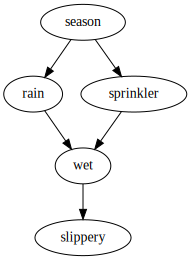

In [2]:
# from http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/
sprinkler = CausalGraphicalModel(
    nodes=["season", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("season", "rain"), 
        ("season", "sprinkler"), 
        ("rain", "wet"),
        ("sprinkler", "wet"), 
        ("wet", "slippery")
    ]
)

# draw the graph using graphviz
sprinkler.draw()

This is an example of a *directed acyclic graph* (or *DAG*). Each variable of interest (or *node*) is represented by an ellipse, and the causal relations between the variables are represented as lines with arrows.  The arrows represent the *directed* nature of the graph, and are meant to reflect specific claims about causal influence.  For example, this model says that raining causes the sidewalk to be wet, and that the sidewalk being wet causes it to be slippery.  We refer to the cause (the node from which an arrow emerges) as a *parent*, and the node that it connects to as a *child*.  

Following graph theory, we refer to the lines connecting two nodes as *edges*.  A *path* is a sequence of edges that connect two nodes, regardless of the direction of the arrows; it can only pass through each variable once. A *directed path* is a path that follows the direction of causal arrows, and thus describes a series of causal interactions. 

The *acyclic* nature of the graph means that there are no cycles; that is, that a directed path never leads back to the same variable where it started.  It is possible to have a *directed cyclic graph*, but we will not discuss these as their analysis is more challenging in the context of SEM.

## What do we mean by "cause"?

The concept of causality has long been and remains a source of great controversy; the discussion here will focus on the particular sense that has long been used by scientists, and that underlies the use of randomized experiments. Let's say that we want to test the claim: "alcohol use causes heart disease through its effects on blood pressure."  This implies the following graph:

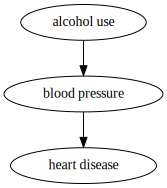

In [3]:
hd = CausalGraphicalModel(
    nodes=["alcohol use", "blood pressure", "heart disease"],
    edges=[
        ("alcohol use", "blood pressure"), 
        ("blood pressure", "heart disease"), 
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
hd.draw()

Intuitively we often think of causality in an as-if (or *counterfactual*) way: If I were to change one thing, how would it affect something else?  We can see that the graph in this example implies two possible interventions that one could make in order to affect heart disease prevalence. First, we could manipulate the level of alcohol use --- for example, through increased taxes on alcoholic beverages, or by administering drugs that cause illness when alcohol is consumed.  Second, we could manipulate blood pressure (e.g. pharmacologically).

The model also tells us how to break the relationships between variables.  Right now, alcohol use is related to heart disease, but if we were to hold blood pressure constant (e.g. using a drug), then the relationship between alcohol use and heart disease should cease to exist if this model were correct.

Finally, the model also tells us something about what *won't* happen if the model is correct, through the direction of its arrows. An intervention that reduces blood pressure should *not* cause changes in alcohol use, because the causal influence does not flow in that direction.



## Causal vs. statistical language

"Correlation is not causation, but it sure is a hint." -- Edward Tufte

If we see a statistical relationship between two variables X and Y, what does that mean in terms of causality?  It could mean any of a number of different things (Glymour, 2006):

1. There are no causal relations between X and Y; the association arose by random fluctuation
2. X causes Y
3. Y causes X
4. The association is *confounded* - that is, a common third factor causes both X and Y
5. The association is *spurious*, due to conditioning on a common effect of X and Y (as we discuss more below).


In order to go from a question about causality to a question that we can assess using statistics, we need to look at the implications of the graphical structure of a causal model on the statistical relations between variables.  In particular, we will focus on *conditional indepdendence*: That is, for which set of variables can we infer that they should be statistically independent, after conditioning on some other variables.

The mathematical foundation for the move from causal to statistical langauge lies in the "calculus of interventions", also known as the *do-calculus* developed by Pearl and his colleagues.  This approach frames causality in terms of the effects of particular interventions on a graph (such as setting a particular variable to a particular value), allowing one to estimate the effect of such an intervention on the resulting probability distribution of variables.  Importantly, it provides a way to move from mathematical statements about the effects of a particular intervention ("$do(x)$") to statements about the probability distributions observed in observational data (i.e. without any experimental control or manipulation). In essence, it provides us with a guide for when we can treat the observation of $X = x$ as equivalent to performing the manipulation $do(X=x)$. We will not go into the details of this foundation in this class; interested readers should consult Pearl's book for a detailed explication.

### Assumptions of the graphical causal modeling approach

The causal modeling approach makes several important assumptions:

1. *Causal Markov assumption*: Every variable in a DAG is independent of all of its non-descendents, conditional on its parents. That is, any variable X is independent of any other variable Y conditioning on the direct causes of X, unless X is an ancestor of Y.
2. *Faithfulness assumption*: The statistical relationships in the data faithfully reflect the causal structure.  In particular, positive and negative causal effects do not perfectly cancel each other out.
3. *Negligible randomness*: We assume that any observed statistical relationships did not arise due to chance.

### d-separation

It turns out that a DAG directly implies a set of statistical independence relations between the variables in the graph.  A criterion known as *d-separation* was proposed by Pearl to allow us to identify these implied conditional independence relationships.  The basic idea is this (from Kline, 2016): A pair of variables X and Y is d-separated by another set of variables Z if and only if Z blocks every path from X to Y.
This can happen in one of two different ways:

1. one of the non-colliders on the path is in Z, or 
2. there is a collider on the path, but neither the collider nor any of its descendants is in Z


Let's look at the three different ways in which a directed graph involving three nodes can be arranged, using different possible causal models of the relation between alcohol use, blood pressure, and heart disease.  

The first example is a *fork*:

Implied conditional Independence Relationship:  [('heart disease', 'blood pressure', {'alcohol use'})]


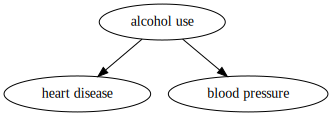

In [4]:
fork = CausalGraphicalModel(
    nodes=["alcohol use", "blood pressure", "heart disease"],
    edges=[
        ("alcohol use", "blood pressure"), 
        ("alcohol use", "heart disease"), 
    ]
)

print("Implied conditional Independence Relationship: ", 
      fork.get_all_independence_relationships())
fork.draw()

In the fork, blood pressure and heart disease are d-separated by alcohol use because the path between blood pressure and heart disease includes the non-collider alcohol use.  Thus, blood pressure and heart disease become independent after conditioning on alcohol use.  The path between blood pressure and heart disease is known as a *back-door* path, because the path is a back door for spurious association between the variables to arise.

The second example is a *chain*, which we already saw above:

Implied conditional Independence Relationship:  [('heart disease', 'alcohol use', {'blood pressure'})]


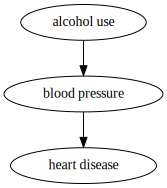

In [5]:
chain = CausalGraphicalModel(
    nodes=["alcohol use", "blood pressure", "heart disease"],
    edges=[
        ("alcohol use", "blood pressure"), 
        ("blood pressure", "heart disease"), 
    ]
)

print("Implied conditional Independence Relationship: ", 
      chain.get_all_independence_relationships())
chain.draw()

In the chain, alcohol use and heart disease are d-separated by blood pressure because the path between alcohol use and heart disease includes the non-collider blood pressure.  Thus, in this case alcohol use and heart disease become independent after conditioning on blood pressure.

The third is example is an inverted fork with a *collider*.  

Implied conditional Independence Relationship:  [('blood pressure', 'alcohol use', set())]


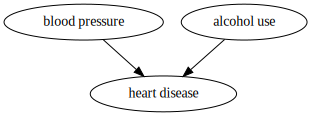

In [6]:
collider = CausalGraphicalModel(
    nodes=["alcohol use", "blood pressure", "heart disease"],
    edges=[
        ("alcohol use", "heart disease"), 
        ("blood pressure", "heart disease"), 
    ]
)

print("Implied conditional Independence Relationship: ", 
      collider.get_all_independence_relationships())
collider.draw()

In this model, blood pressure and alcohol use are independent (unconditionally) because there is no path between them. However, they actually become *dependent* once we conditionalize on heart disease (the node where the inputs collide).  This can give rise to some unintuitive phenomena, which go the names of "Berkson's paradox" or "conditioning on a common effect" (which we return to below).


We can use the d-separation criterion to automatically identify all of the pairwise independence relations in the sprinkler example:

In [7]:
sprinkler.get_all_independence_relationships()

[('rain', 'slippery', {'wet'}),
 ('rain', 'slippery', {'season', 'wet'}),
 ('rain', 'slippery', {'sprinkler', 'wet'}),
 ('rain', 'slippery', {'season', 'sprinkler', 'wet'}),
 ('rain', 'sprinkler', {'season'}),
 ('slippery', 'season', {'wet'}),
 ('slippery', 'season', {'sprinkler', 'wet'}),
 ('slippery', 'season', {'rain', 'sprinkler'}),
 ('slippery', 'season', {'rain', 'wet'}),
 ('slippery', 'season', {'rain', 'sprinkler', 'wet'}),
 ('slippery', 'sprinkler', {'wet'}),
 ('slippery', 'sprinkler', {'season', 'wet'}),
 ('slippery', 'sprinkler', {'rain', 'wet'}),
 ('slippery', 'sprinkler', {'rain', 'season', 'wet'}),
 ('season', 'wet', {'rain', 'sprinkler'}),
 ('season', 'wet', {'rain', 'slippery', 'sprinkler'})]

These implied conditional independence relationships provide one way of testing the fit of a model, because they imply that particular partial correlations in the data should tend to zero (or "vanish") (e.g. $\rho_{rain, slippery|wet}$).  This approach is used the in [TETRAD software ](http://www.phil.cmu.edu/tetrad/) to search for causal structure in data; we will not discuss causal discovery in this class, but interested readers should read [Causation, Prediction, and Search by Spirtes et al.](https://mitpress.mit.edu/books/causation-prediction-and-search-second-edition).

Note that in an important sense, it is the *missing* edges in the graph that are in some ways most important, because they reflect strong claims about an absolute lack of causal influence between the nodes.  For this reason, when generating a causal graph, Pearl (2009) suggests that one starts with bidrectional arrows between each pair of nodes, which "should be deleted only by well-motivated justifications, such as the unlikely existence of a common cause for the two variables and the unlikely existence of selection bias. Although we can never be cognizant of all the factors that may affect our variables, substantive knowledge sometimes permits us to state that the influence of a possible common factor is not likely to be significant." (Pearl, 2009, p. 163).

## Markov equivalence

In some cases different graphs can have the same statistical implications; they are said to comprise a *Markov equivalence class*.  For example, take the following three graphs:


![](me1.png)  |  ![](me2.png) |  ![](me3.png)

All of these have the same set of implied conditional independencies:

`('X', 'W', {'Z'}), 
('X', 'W', {'Z', 'Y'}), 
('X', 'Y', {'Z'}), 
('X', 'Y', {'Z', 'W'})`

This means that we could not distinguish between these models based on the conditional independence relations between the variables, regardless of the amount of data; if we tried to do so we would be wasting our time.  As in this example, these kinds of equivalence classes will generally reflect cases where the direction of particular edges varies between the members of the equivalence class.  There are other methods that can be used to determine the direction of these arrows, but they go beyond standard linear models such as SEM.

## Unobserved causes

In the former examples, all of the variables in our graphs were observable, but in many cases (including those of greatest interest for SEM), there are variables that are unobservable, or *latent* in SEM language.  In order to be considered a proper causal graph, the graph must also include any known but unobserved causes.  If we don't include these, then the causal assumptions fail.

This issue arises regularly in observational epidemiological studies.  Let's return to our example of the relation between alcohol consumption and heart disease, via blood pressure.  We interpret this to say that if we could hold blood pressure constant (e.g. using a drug that controlled it), then alcohol consumption and heart diseease would become conditionally independent.  However, it is generally known that people who take supposedly "healthy" actions in one domain will often take those actions in other domains as well; this is know as the ["healthy user bias"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3077477/). For example, people who drink less for health reasons are also likely to exercise more, which can improve cardiovascular health, either by affecting blood pressure directly or by other mechanisms.  There are also likely to be other factors that affect both healthy user bias and heart disease (e.g. socioeconomic status).  Thus, the true causal graph probably looks more like this:

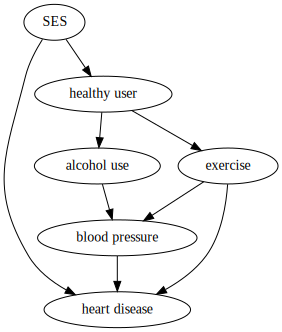

In [8]:
hd2 = CausalGraphicalModel(
    nodes=["alcohol use", "blood pressure", "heart disease", "healthy user", "exercise", "SES"],
    edges=[
        ("alcohol use", "blood pressure"), 
        ("blood pressure", "heart disease"), 
        ("healthy user", "alcohol use"),
        ("exercise", "blood pressure"),
        ("healthy user", "exercise"),
        ("exercise", "heart disease"),
        ("SES", "healthy user"),
        ("SES", "heart disease")
    ]
)

hd2.draw()


In [9]:
hd2.get_all_independence_relationships()

[('heart disease', 'healthy user', {'SES', 'alcohol use', 'exercise'}),
 ('heart disease', 'healthy user', {'SES', 'blood pressure', 'exercise'}),
 ('heart disease',
  'healthy user',
  {'SES', 'alcohol use', 'blood pressure', 'exercise'}),
 ('heart disease',
  'alcohol use',
  {'blood pressure', 'exercise', 'healthy user'}),
 ('heart disease', 'alcohol use', {'SES', 'blood pressure', 'exercise'}),
 ('heart disease',
  'alcohol use',
  {'SES', 'blood pressure', 'exercise', 'healthy user'}),
 ('healthy user', 'blood pressure', {'alcohol use', 'exercise'}),
 ('healthy user', 'blood pressure', {'SES', 'alcohol use', 'exercise'}),
 ('healthy user',
  'blood pressure',
  {'SES', 'alcohol use', 'exercise', 'heart disease'}),
 ('alcohol use', 'exercise', {'healthy user'}),
 ('alcohol use', 'exercise', {'SES', 'healthy user'}),
 ('alcohol use', 'SES', {'healthy user'}),
 ('alcohol use', 'SES', {'exercise', 'healthy user'}),
 ('alcohol use', 'SES', {'blood pressure', 'healthy user'}),
 ('alcoho

If we don't have a measurement of healthy user bias (which we generally don't), then healthy user status must be treated as an unobserved variable. 

## Confounding

Another way that we might describe the situation above is that the relationship between dietary fat intake and heart disease is *confounded*.  In the language of graphical causal modeling, we would say there is a *back-door path* that connects these two variables. For this graph we can identify the back-door paths automatically:

In [10]:
hd2.get_all_backdoor_paths('alcohol use', 'heart disease')

[['alcohol use',
  'healthy user',
  'exercise',
  'blood pressure',
  'heart disease'],
 ['alcohol use', 'healthy user', 'exercise', 'heart disease'],
 ['alcohol use', 'healthy user', 'SES', 'heart disease']]

One useful feature of causal modeling is that we can also identify which other variables can be conrtrolled in order to eliminate any potential confounding, by identifying those sets that block all of the back-door paths between our two variables of interest:

In [11]:
hd2.get_all_backdoor_adjustment_sets('alcohol use', 'heart disease')

frozenset({frozenset({'SES', 'exercise'}),
           frozenset({'healthy user'}),
           frozenset({'SES', 'healthy user'}),
           frozenset({'exercise', 'healthy user'}),
           frozenset({'SES', 'exercise', 'healthy user'})})

Thus, *assuming that this causal model is correct and complete*, we can identify the total causal effect of alcohol use on heart disease if we control for any of the sets of variables identifed as an *adjustment set*.

## Framing simple regression as a causal model

Although results from regression analyses are often framed in terms of causal language, the regression model itself is inherently agnostic to the direction of influence between the different variables.  Let's take a particular regression equation:

$$
y_i = \alpha_y + \beta_{yx} * x_i + \epsilon_{yi}
$$

where $\alpha$ is the intercept and $\beta_{yx}$ is the slope for y against x.  We could equivalently write this as:

$$
x_i = \alpha_x + \beta_{xy} * y_i + \epsilon_{xi}
$$

where:

$$
\alpha_x = \frac{-\beta_{yx}}{\alpha_y}, 
$$

$$
\beta_{xy} = \frac{1}{\beta_{yx}}, 
$$

and

$$
\epsilon_{xi} = \frac{\epsilon_{yi}}{-\beta_{yx}}
$$


Thus, from the standpoint of regression, it is perfectly legitimate to use either the X or Y variable as the predictor, since the goal is simply to predict the value of one variable conditional on the value of another.

But now think about this from the standpoint of a *structural model*.  The first equation can be drawn as follows:

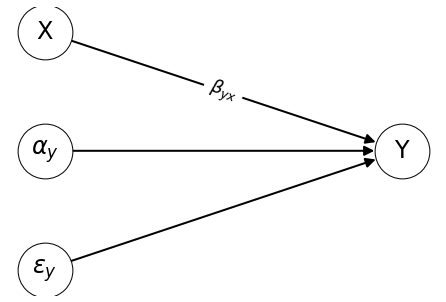

In [12]:
G = nx.DiGraph()
G.add_edge('X', 'Y')
G.add_edge('e', 'Y')
G.add_edge('a', 'Y')
pos = {'X':[0, 1], 'e':[0, 0], 'Y':[0.5, 0.5], 'a':[0, 0.5]}
nx.draw(G, pos, node_size=3000, node_color='white', edgecolors='black', width=2, arrowsize=20)
edge_labels={('X', 'Y'): r'$\beta_{yx}$'}
node_labels={i:i for i in G.nodes}
node_labels['e'] = r'$\epsilon_y$'
node_labels['a'] = r'$\alpha_y$'
_ = nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=24)
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18)


The second equation would be drawn as:

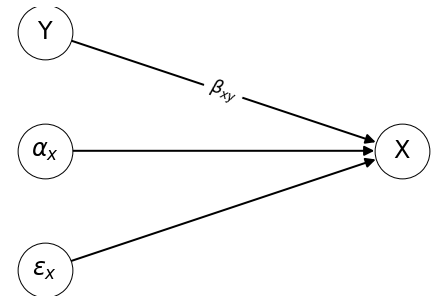

In [13]:
G = nx.DiGraph()
G.add_edge('Y', 'X')
G.add_edge('e', 'X')
G.add_edge('a', 'X')
pos = {'Y':[0, 1], 'e':[0, 0], 'X':[0.5, 0.5], 'a':[0, 0.5]}
nx.draw(G, pos, node_size=3000, node_color='white', edgecolors='black', width=2, arrowsize=20)
edge_labels={('X', 'Y'): r'$\beta_{xy}$'}
node_labels={i:i for i in G.nodes}
node_labels['e'] = r'$\epsilon_x$'
node_labels['a'] = r'$\alpha_x$'
_ = nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=24)
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18)


It's clear from looking at these two causal graphs that they make very different predictions; in particular, whereas the first graph implies that manipulating X should have an effect on Y, the second graph would imply that changing the value of X should have no effect on the value of Y.

The causal model requires several assumptions ([Bollen & Pearl, 2012](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2343821)):

1. Linearity: the effect of a unit change in X on Y is the same regardless of the value of X
2. Exclusion: if we hold X constant, then changes to other variables in the model (e.g. variables Z that affect the value of X) will not have any effect on Y
3. Homogeneity: the causal effect $\beta_{yx}$ is the same for all units in the population.

Thus, a causal model can be thought of as one or more regression equations along with a set of causal assumptions.

# Berkson's paradox

We saw above that if we condition on a collider (i.e. a common effect), we induce an association between initially independent variables.  Think about the sprinkler example for a moment. If we know that either the sprinkler or rain can cause the sidewalk to be wet, then if we know that it's is wet and that it was raining, then it becomes less likely that the sprinkler caused the wetness; in the langauge of Bayesian reasoning, we have "explained away" the wetness once we know that it has rained.


Berkson's paradox has important consequences in the context of regression analysis, where including a common effect of the x and y variables as a regressor in the model can introduce spurious relationships.  To see this in action, let's set up a (somewhat contrived) situation that can help us understand how conditioning on a collider (or the child of a collider) can affect regression parameter estimates.  Here we will create a simulated example of conditioning on a collider to see how it affects regression parameters.  

In [14]:
npts = 100
np.random.seed(67895)
colliderDf = pd.DataFrame({'x1': np.random.randn(npts),
                           'x3': np.random.randn(npts)})
colliderDf['x2'] = colliderDf.mean(1) + np.random.randn(npts)*.1

colliderDf.corr()

,x1,x3,x2
x1,1.000000,0.000601,0.726513
x3,0.000601,1.000000,0.675513
x2,0.726513,0.675513,1.000000


Let's say that we run a linear regression for x1 vs x3:

In [15]:
import statsmodels.api as sm
model = sm.OLS(colliderDf['x1'], colliderDf['x3'])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     x1   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.010
Method:                 Least Squares   F-statistic:                            0.05556
Date:                Wed, 20 May 2020   Prob (F-statistic):                       0.814
Time:                        17:56:13   Log-Likelihood:                         -149.31
No. Observations:                 100   AIC:                                      300.6
Df Residuals:                      99   BIC:                                      303.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x3             0.0253      0.107      0.236      0.814      -0.188       0.238
==============================================================================
Omnibus:                        5.563   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                8.391
Skew:                           0.061   Prob(JB):                       0.0151
Kurtosis:                       4.414   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here we see that there is no significant relationship between the two variables, but the coefficient for x3 is slightly positive.  However, if we add the collider x2 to the model:

In [16]:
model2 = sm.OLS(colliderDf['x1'], colliderDf[['x3', 'x2']])
result2 = model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     x1   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              1589.
Date:                Wed, 20 May 2020   Prob (F-statistic):                    2.11e-75
Time:                        17:56:13   Log-Likelihood:                          26.116
No. Observations:                 100   AIC:                                     -48.23
Df Residuals:                      98   BIC:                                     -43.02
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x3            -0.9745      0.026    -37.827      0.000      -1.026      -0.923
x2             1.9659      0.035     56.349      0.000       1.897       2.035
==============================================================================
Omnibus:                        0.937   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.626   Jarque-Bera (JB):                1.038
Skew:                          -0.207   Prob(JB):                        0.595
Kurtosis:                       2.721   Cond. No.                         2.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we see that the effect of x3 is highly significant in the negative direction! This is because when one conditionalizes on the collider, the only remaining variance must necessarily move in the opposite direction.  This example shows how insights from graphical causal models are useful even if one doesn't wish to explicitly test causal hypotheses.

## SEM as a causal model

Whereas graphical models generally do not make any particular claims about the mathematical structure of the model, SEM is framed in terms of a set of linear models.  That is, graphical models are *nonparametric* whereas SEMs are a particular *parametric* instantiation of those models.  [Pearl (2012)](https://ftp.cs.ucla.edu/pub/stat_ser/r370.pdf) lays out the logic of structural equation modeling (SEM) in the context of graphical causal models.

The inputs to the model are:

1. A set $A$ of causal assumptions (justified on scientific grounds) that are encoded in a model $M_A$ expressed as a directed graph.
2. A set $Q$ of questions concerning causal relations between the variables in the model --- e.g. "What is the effect of treatment X on outcome Y?"
3. A set $D$ of data (experimental or observational) presumably generated by a process consistent with assumptions $A$.

The outputs from the process of modeling are:

1. A set $A*$ of statements regarding the logical implications of $A$, separate from the data, such as the conditional independences implicated by the graph.
2. A set $C$ of data-based claims regarding the magnitudes or likelihoods of the questions in $Q$ given the data $D$ and assumptions $A$.
3. A set $T$ of testable statistical implications of $A$, such as the predicted vanishing of particular partial correlations that is implied by conditional independence relationships.

Note that SEM can never provide evidence in favor of the causal assumptions; those serve somewhat like the null hypothesis in standard statistical testing. What it can do is allow us to (sometimes) ask questions out the specific causal effects in the model, and therefore disconfirm particular claims (e.g. by showing that a particular claimed causal effect is not different from zero).  They can also provide us estimates of the magnitude of the causal effect, which could be useful for guiding our behavior (such as treatment or policy intervention).

As Bollen and Pearl (2012) say:

>Lest there be any doubt:
SEM does not aim to establish causal relations from associations alone.
Perhaps the best way to make this point clear is to state formally and unambiguously
what SEM does aim to establish. SEM is an inference engine that takes in two inputs, qualitative causal assumptions and empirical data, and derives two logical consequences of these inputs: quantitative causal conclusions and statistical measures of fit for the testable implications of the assumptions. Failure to fit the data casts doubt on the strong causal assumptions of zero coefficients or zero covariances and guides the researcher to diagnose, or repair the structural misspecifications. Fitting the data does not “prove” the causal assumptions, but it makes them tentatively more plausible. Any such positive results need to be replicated and to withstand the criticisms of researchers who suggest other models for the same data.



## Potential outcomes framework

Another prominent approach to causal inference is known as the *potential outcomes* framework, most strongly associated with Donald Rubin. In this framework, causal inference is framed as a missing data problem.  For example, let's say that we want to know whether going to college results in greater income.  For any particular individual, we only have data for the outcome that actually occurred, and not for the counterfactual outcome. 

The potential outcomes approach has often been framed by its proponents as being somehow in conflict with and superior to the graphical causal modeling approach.  However, Pearl has shown that the two approaches are logically equivalent, such that any statement that can be expressed in one framework can be translated directly into the other.  Thus, one should feel free to take advantage of the framework that seems most suitable to one's particular analyses.  We will not discuss the details of how to implement this framework in this course, as I personally find the potential outcomes framework somewhat unwieldy to think about.

## Instrumental variables

A common approach in econometrics and epidemiology to assess causal influence is the use of *instrumental variables*.  These are variables that are related to the putative cause, and unrelated to any of the unknown confounding causes (that is, the error).  These are often thought of as "natural experiments" in which the instrumental variable provides a manipulation of the putative cause, allowing us to assess its effect on the outcome.

One example where this has been used in epidemiology is *Mendelian randomization*, which takes advantage of the fact that genetic variants are transmitted randomly.  As an example, let's take the case of the ALDH2 variant, in which a particular allele results in an unpleasant "flush response" due to the reduced breakdown of aldehyde, and leads to much lower levels of alcohol consumption in people who carry two copies of that allele.  

We can use the presence or absence of the particular ALDH2 allele as an instrumental variable.  Let's first look at the causal graph relating alcohol use to blood pressure and heart disease, including unknown confounders that could potentially confound any observed correlation between alcohol use and heart disease:

Back door paths between alcohol use and heart disease:  [['alcohol use', 'unknown confounders', 'heart disease']]


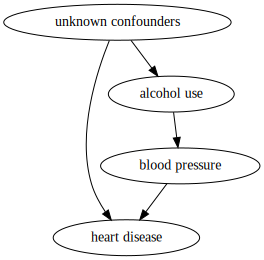

In [17]:
confounding = CausalGraphicalModel(
    nodes=["alcohol use", "blood pressure", "heart disease", 'unknown confounders'],
    edges=[
        ("alcohol use", "blood pressure"), 
        ("blood pressure", "heart disease"),
        ('unknown confounders', 'alcohol use'),
        ('unknown confounders', 'heart disease')
    ]
)

#print("Implied conditional Independence Relationship: ", 
#      confounding.get_all_independence_relationships())
print("Back door paths between alcohol use and heart disease: ",
      confounding.get_all_backdoor_paths('alcohol use', 'heart disease'))
confounding.draw()

Now let's draw the graph including the ALDH2 allele. Note that we must make the following assumptions ([Davies, 2018](https://www.bmj.com/content/362/bmj.k601)):

- the genetic variant affects the causal factor (which we know from previous research)
- there are no unmeasured confounders between the genetic variant and the outcome (e.g. population stratification)
- the genetic variant only affects the outcome via the causal factor of interest (no alternative pathways)

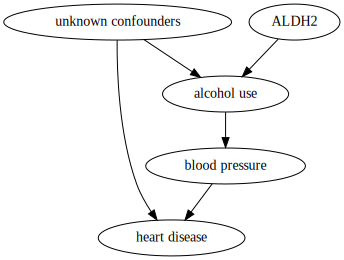

In [18]:
IV = CausalGraphicalModel(
    nodes=["alcohol use", "blood pressure", "heart disease", 'unknown confounders', 'ALDH2'],
    edges=[
        ("alcohol use", "blood pressure"), 
        ("blood pressure", "heart disease"),
        ('unknown confounders', 'alcohol use'),
        ('unknown confounders', 'heart disease'),
        ('ALDH2', 'alcohol use')
    ]
)

IV.draw()

Given this, we can estimate the causal effect of alcohol use on blood pressure as follows:

$$
\text{causal effect} = \frac{r(\text{ALDH2}, \text{heart disease})}{r(\text{ALDH2}, \text{alcohol use})}
$$

This is effectively telling us how much of the effect of the genetic variant on alcohol use gets transmitted to the ultimate outcome of heart disease.

## Gaussian graphical models



If our data are treated as samples from a Gaussian distribution, then we can take advantage of some known facts regarding the relation between the inverse covariances and the underlying graph. In particular, if two variables have zero inverse covariance, then they are conditionally independent given all other variables.

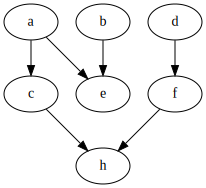

In [19]:
from causalgraphicalmodels.csm import StructuralCausalModel, \
    linear_model, logistic_model

noise_scale = .5
n_samples=2000
big_csm = StructuralCausalModel({
    "a": lambda n_samples: np.random.normal(size=n_samples),
    "b": lambda n_samples: np.random.normal(size=n_samples),
    "e": linear_model(("a","b"), [1, 1], noise_scale=noise_scale),
    "c": linear_model(("a",), [1], noise_scale=noise_scale),
    "d": linear_model(("c", "h"), [1, 1], noise_scale=noise_scale),
    "h": linear_model(("c", "f"), [1, 1], noise_scale=noise_scale),
    "d": lambda n_samples: np.random.normal(size=n_samples),
    "f": linear_model(("d"), [1], noise_scale=noise_scale),
})

big_csm.cgm.draw()

Text(0.5, 1.0, 'inverse covariance')

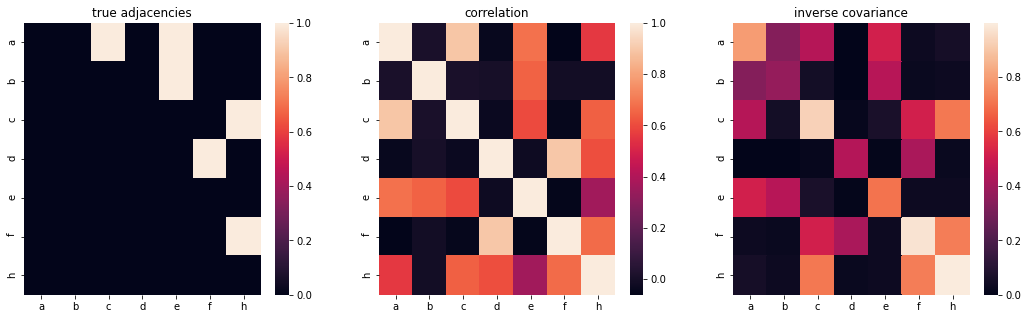

In [20]:
# plot the matrices

colnames = list(big_csm.cgm.dag.nodes)
colnames.sort()

simulated_data = big_csm.sample(1000)[colnames]

simulated_data = (simulated_data - simulated_data.mean(0))/simulated_data.std(0)
corrmtx = np.corrcoef(simulated_data.T)
#corrmtx[np.tril_indices_from(corrmtx)] = 0
corrmtx = pd.DataFrame(corrmtx,
        columns=simulated_data.columns,
        index=simulated_data.columns)

inv_cov = np.abs(np.linalg.inv(simulated_data.cov()))
#inv_cov[np.tril_indices_from(inv_cov)] = 0
inv_cov = (inv_cov - np.min(inv_cov))/np.max(inv_cov)
#inv_cov[np.tril_indices_from(inv_cov)] = 0

inv_cov = pd.DataFrame(inv_cov,
        columns=simulated_data.columns,
        index=simulated_data.columns)

true_graph = np.zeros(corrmtx.shape)
true_graph[np.tril_indices_from(inv_cov)] = 0
true_graph = pd.DataFrame(true_graph,
                          columns=simulated_data.columns,
                          index=simulated_data.columns)

for e in big_csm.cgm.dag.edges:
    true_graph.loc[e[0], e[1]] = 1
    
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.heatmap(true_graph) #, cmap='gray', vmin=0, vmax=1)
plt.title('true adjacencies')
plt.subplot(1,3,2)
sns.heatmap(corrmtx) #, vmin=0, vmax=1)
plt.title('correlation')
plt.subplot(1,3,3)
sns.heatmap(np.abs(inv_cov)) #, cmap='gray')
plt.title('inverse covariance')


In this case the inverse covariance is fairly close to the true adjacencies, though you should notice that it is symmetric, which means that it is estimating the adjacencies in an *undirected* graph (i.e. no arrows).

In this small example we had relatively few features, so inversion of the covariance matrix works reasonably well. However, when the number of features grows, estimation of the inverse covariance becomes unstable, and we need to use a regularized method for estimating the inverse covariance.  Let's create an example to see his in action.  We will generate a random DAG with 100 nodes and 100 edges.

In [21]:
# function to generate a random DAG
#from https://ipython.org/ipython-doc/stable/parallel/dag_dependencies.html
rng = np.random.RandomState(1)
  
def random_dag(nodes, edges):
    """Generate a random Directed Acyclic Graph (DAG) with a given number of nodes and edges."""
    G = nx.DiGraph()
    for i in range(nodes):
        G.add_node(i)
    while edges > 0:
        a = rng.randint(0,nodes-1)
        b=a
        while b==a:
            b = rng.randint(0,nodes-1)
        G.add_edge(a,b)
        if nx.is_directed_acyclic_graph(G):
            edges -= 1
        else:
            # we closed a loop!
            G.remove_edge(a,b)
    return G

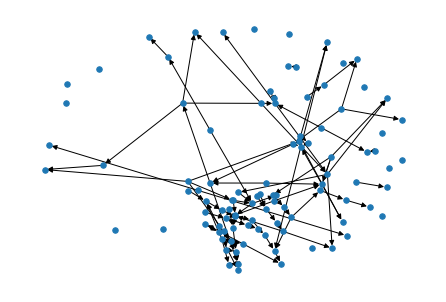

In [22]:
np.random.seed(1)
G = random_dag(100,100)
nx.draw_spring(G, node_size=30)


Now let's create a causal model using this DAG. For any node with no inbound connections, its signal is simply Gaussian noise, whereas signal for the other nodes are generated by simply adding the relevant inputs based on the graph.

In [23]:
# generate a very large network to show problems with inversion of covariance mtx

# first generate some input nodes:

n_samples = 1000
noise_scale = 5

model_dict = {}


# first find all nodes with positive out-degree and zero in-degree, to be our inputs
in_degree = dict(G.in_degree)
out_degree = dict(G.out_degree)

input_nodes = []
for node in G.nodes:
    if in_degree[node] == 0 and out_degree[node] > 0:
        input_nodes.append(node)

# add input nodes to dict

for node in input_nodes:
    model_dict['%d' % node] = lambda n_samples: rng.normal(size=n_samples, scale=noise_scale)
    

# add remaining nodes

for node in G.nodes:
    if node in input_nodes:
        continue
    parents = ['%d' % i for i in G.predecessors(node)]
    weights = list(rng.rand(len(parents))*0.25 + 0.75)
    if len(parents) > 0:
        model_dict['%d' % node] = linear_model(parents, weights, noise_scale=noise_scale)
    else:
        model_dict['%d' % node] = lambda n_samples: rng.normal(size=n_samples, scale=noise_scale)


very_big_csm = StructuralCausalModel(model_dict)
#very_big_csm.cgm.draw()

In [24]:
simulated_data = very_big_csm.sample()

corrmtx = simulated_data.corr()

true_graph = np.zeros(corrmtx.shape)
true_graph = pd.DataFrame(true_graph,
                          columns=simulated_data.columns,
                          index=simulated_data.columns)

for e in very_big_csm.cgm.dag.edges:
    true_graph.loc[e[0], e[1]] = 1

inv_cov = np.linalg.inv(simulated_data.cov())

inv_cov_df = pd.DataFrame(inv_cov,
                          columns=simulated_data.columns,
                          index=simulated_data.columns)

Text(0.5, 1.0, 'inverse covariance')

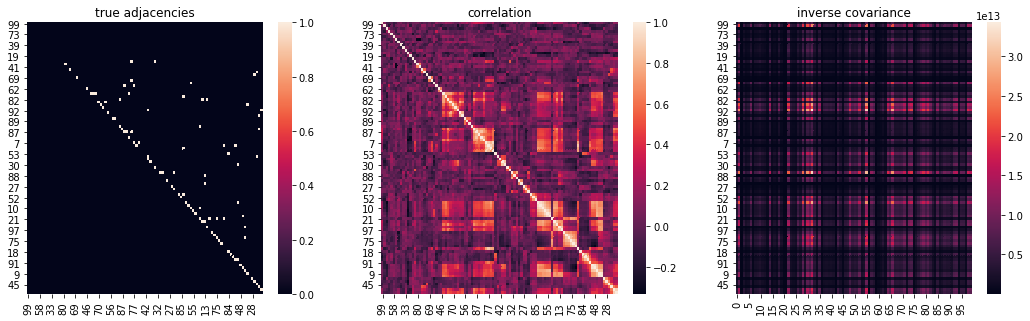

In [30]:
# plot the true adjacency matrix, correlation matrix, and estimated inverse covariance

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.heatmap(true_graph) #, cmap='gray', vmin=0, vmax=1)
plt.title('true adjacencies')
plt.subplot(1,3,2)
sns.heatmap(corrmtx) #, vmin=0, vmax=1)
plt.title('correlation')
plt.subplot(1,3,3)
abs_icov_df = pd.DataFrame(np.abs(inv_cov), index=inv_cov_df.index)
sns.heatmap(abs_icov_df) #, cmap='gray')
plt.title('inverse covariance')


You can see that some of the values in the inverse covariance estimate are exceedingly large, due to the instability of inverting this matrix.  This probably makes it a poor estimator of the true graph - but how would we know?

### The receiver operating characteristic (ROC) curve

It is often useful to compare a continuous value (such as the estimated inverse covariance) with a binary ground truth value in order to assess the accuracy of the measure. One useful way to do this is via a receiver operating characteristic (ROC) curve, which plots the level of true positives against false positives for a range of thresholds on the continuous value.  We can compute this using the `roc_curve()` function from scikit-learn.  
The ROC curve also provides a way to assess overall accuracy across a range of thresholds, by estimating the area underneath the curve.  This area is 1 for a perfect classifier (that is, it has 100% true positives regardless of the rate of false positives), whereas it is 0.5 for a classifier that is guessing (since the true positive rate will be equal to the false positive rate, cutting the square in half.  

Let's see what this looks like for a couple of examples.  First, let's generate a binary vector and a random vector (uniformly distributed) and compare them. The ROC should fall roughly along the diagonal.

AUC: 0.5166066426570628


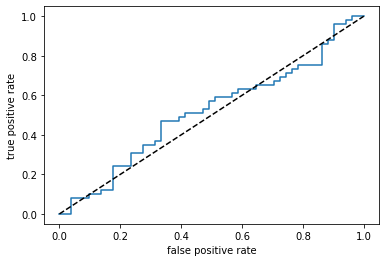

In [33]:
binary_true = (np.random.randn(100)>0).astype(int)
normal_est = np.random.randn(100)

print('AUC:', roc_auc_score(binary_true, normal_est))
fpr, tpr, thresholds = roc_curve(binary_true, normal_est)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('false positive rate')
_ = plt.ylabel('true positive rate')


Now let's look at an example where performance is perfect:

AUC: 1.0


Text(0, 0.5, 'true positive rate')

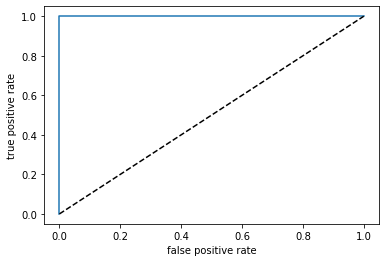

In [34]:

print('AUC:', roc_auc_score(binary_true, binary_true))
fpr, tpr, thresholds = roc_curve(binary_true, binary_true)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')


Now let's look at the ROC curve for our estimated inverse covariance matrix compared to the true graph.

Here we create a function that takes in a precision matrix and a true adjacency matrix, and computes the ROC curve on the upper triangles of the matrices.

In [35]:
def get_roc(precision, true_graph):
    """
    compute ROC curve and area under curve for two data frames
    using only the upper triangle
    
    parameters:
    -----------
    precision: pandas DataFrame with estimated precision
    true_graph: pandas DataFrame with true adjacency matrix (binary)
    
    returns:
    --------
    resultDf: data frame containing:
        tpr: true positive rates for each threshold
        fpr: false positive rates for each threshold
        thresholds: thresholds used
    """
    assert np.all(precision.index == true_graph.index)
    assert np.all(precision.columns == true_graph.columns)

    prec_triu = precision.values[np.triu_indices_from(precision,1)]
    true_triu = true_graph.values[np.triu_indices_from(true_graph,1)]

    from sklearn.metrics import roc_curve, roc_auc_score

    fpr, tpr, thresholds = roc_curve(true_triu, prec_triu)
    print('AUC:', roc_auc_score(true_triu, prec_triu))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    resultDf = pd.DataFrame({'tpr': tpr, 
                            'fpr': fpr,
                            'thresholds': thresholds})
    perfect_recall = np.where(tpr == 1)
    return(resultDf)



Here is the curve for our inverse covariance estimate from above:

AUC: 0.6550018844391139


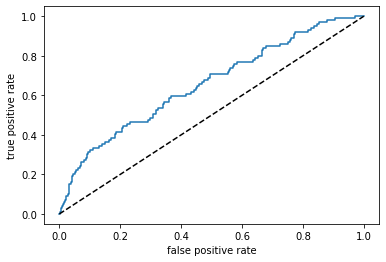

In [36]:
_ = get_roc(inv_cov_df, true_graph)

We see that it does terribly, with a area under the curve of slightly less than 0.5.

**Question**: What would it mean if area under the curve was far below the diagonal?

### Graphical lasso

The graphical lasso uses L1 regularization to estimate the inverse covariance.  Now let's look at whether the graphical lasso can do a better job of correctly identifying the direct adjacencies for our dataset.

In [40]:
model = GraphicalLassoCV(alphas=10, n_refinements=4, max_iter=1000)
model.fit(simulated_data)
cov_ = model.covariance_
prec_ = np.abs(model.precision_)
prec_glasso = (prec_ - np.min(prec_))/np.max(prec_)

/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 8.728e-03
  % (max_iter, d_gap), ConvergenceWarning)


AUC: 0.9989901072152154


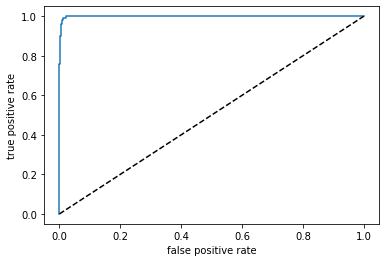

In [41]:
prec_glasso_df = pd.DataFrame(prec_glasso,
    columns=simulated_data.columns,
    index=simulated_data.columns)

resultDf = get_roc(prec_glasso_df, true_graph)

Here we see that the graphical lasso does a very good job of estimating the true underlying adjacencies.